# RipsLowerstar bifiltrations 

In [1]:
import multipers as mp
import multipers.filtrations as mpf
import gudhi as gd
import matplotlib.pyplot as plt
import numpy as np

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


## The Rips complex

In this example, we show how to extend Gudhi simplextrees (see, e.g., [here](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-simplex-Trees.ipynb)),
to the multiparameter settings. 

We will consider the Rips Complex simplex here, which can be defined as follows.
Consider $X = (x_1, \ldots,x_n)$ a point cloud in a metric space, and its pairwise distance matrix $D=\left(d(x_i,x_j)\right)_{1\le i,j\le n}$

Now, for any $t\ge 0$, we consider the so-called simplicial complex 
$$\mathrm{Rips}(X)_t:= \left\{ \sigma \subseteq \{x_1, \ldots, x_n\} \mid \mathrm{diam}(\sigma)\le t \right\}, \quad \textnormal{where }\mathrm{diam}(\sigma) = \max_{x,y\in \sigma} d(x,y)$$

We will see that this mathematical structure is well suited to encode, *at any scale*, topological information.
In the meantime, let's build it on a simple dataset.

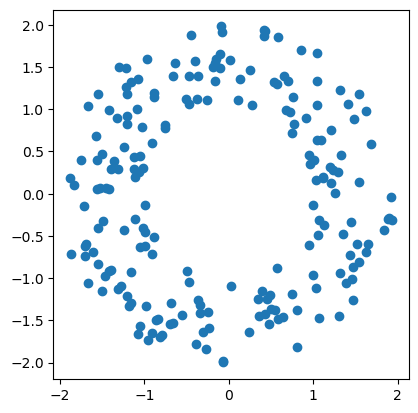

In [2]:
from multipers.data.synthetic import noisy_annulus
np.random.seed(0)
X = noisy_annulus(200, 0)
plt.scatter(*X.T)
plt.gca().set_aspect(1)

Intuitively in this example, for small radii, the points are disconnected and the circle annulus is not preserved, but for large radii, the hole is closed.

Computing the rips for all possible parameters $t\in \mathbb R_+$ hence should allow us to recover the topological feature here, i.e., the cycle. 

![RipsComplex](./rips_complex.png)

## The Rips filtration

The Rips complex can easily be built in gudhi, and encoded in a well-suited structure for this: the `SimplexTree`.

In [3]:
st = gd.RipsComplex(points = X).create_simplex_tree(max_dimension=2)

Then the persistence of topological features along this time parameter can be encoded in a persistence barcode. 
We see in the example below that only one feature survives for a "long time"; it corresponds to this hole. 

/home/dloiseau/micromamba/envs/312/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Axes: title={'center': 'Persistence barcode'}>

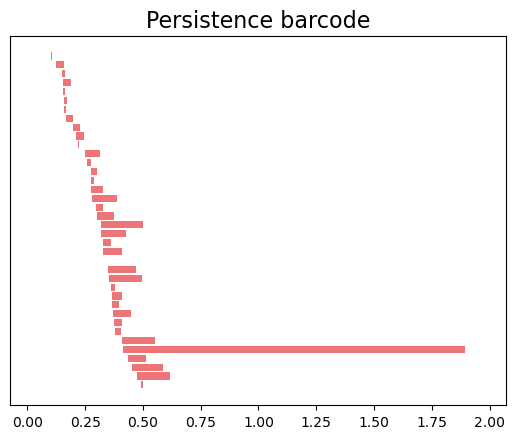

In [4]:
st.compute_persistence()
pers = st.persistence_intervals_in_dimension(1)
gd.plot_persistence_barcode(pers)

### With the noise
Adding (diffuse) noise to this dataset however significantly reduces what we can recover.

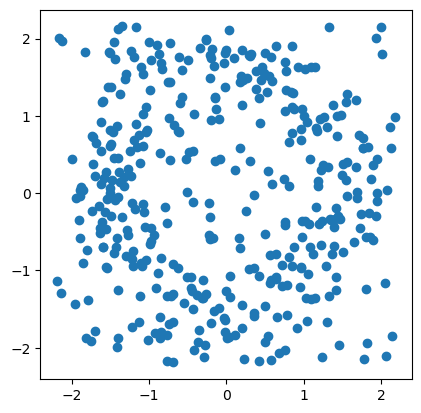

In [5]:
np.random.seed(2)
X = noisy_annulus(200, 200)
plt.scatter(*X.T)
plt.gca().set_aspect(1)

<Axes: title={'center': 'Persistence barcode'}>

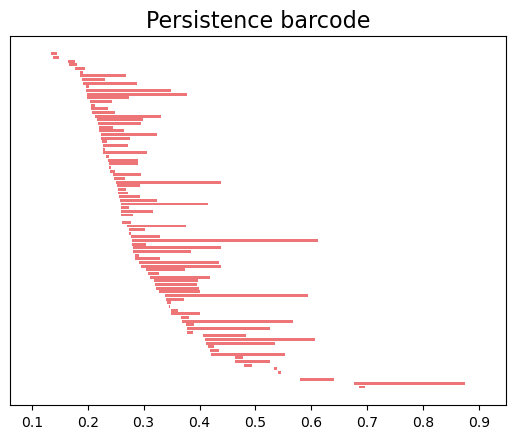

In [6]:
st = gd.RipsComplex(points = X).create_simplex_tree()
st.collapse_edges(2) # Little optimization trick
st.expansion(2)
st.compute_persistence()
pers = st.persistence_intervals_in_dimension(1)
gd.plot_persistence_barcode(pers)

## The Rips-Codensity bifiltration

A *simple-to-implement* fix to this issue is to *add a parameter* to take into account the concentration of the sampling.
Indeed, the noise is usually less concentrated than the signal.

Given a density estimation $f$ of the sampling measure $\mu$, i.e., $f \simeq \frac{\mathrm d\mu}{\mathrm dx\mathrm dy}$,
we can consider the following bifiltration, whose first parameter is the *radius* and the second the *codensity*:

$$\mathrm{RipsCodensity}_{r,d} := \left\{ \sigma \subseteq X \mid \mathrm{diam}(\sigma) \le t, \min_{x\in\sigma} f(x)\ge d\right\}$$

As the second parameter of the filtration only depends of the values of $f$ on the $0$-simplices, i.e., the points of $X$, this second parameter is a so-called *lowerstar* filtration.
This function accepts any point cloud, or distance matrix, with an array $(\mathrm{num\_points}, \mathrm{num\_additional\_axis})$ for additional lowestar parameters.

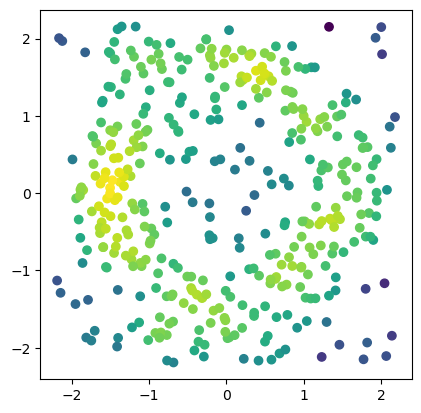

In [7]:
from sklearn.neighbors import KernelDensity
f= - KernelDensity(bandwidth=.2).fit(X).score_samples(X) # minus to reverse the order.
plt.scatter(*X.T, c=f, cmap="viridis_r")
plt.gca().set_aspect(1)
st = mpf.RipsLowerstar(points=X, function=f).collapse_edges(-2).expansion(2) # Same trick as previously

Note that this can be achieved in one line by calling the specialized function `RipsCodensity`.

In [8]:
st = mpf.RipsCodensity(points=X, bandwidth=.1).collapse_edges(-2).expansion(2) # Same trick as previously

Looking at the different pairs of $(\mathrm{radius},\mathrm{density})$ threshold, we see that there is only one shape that is significantly bigger than the other here: our initial circle !

Text(0.5, 1.0, 'RipsCodensity')

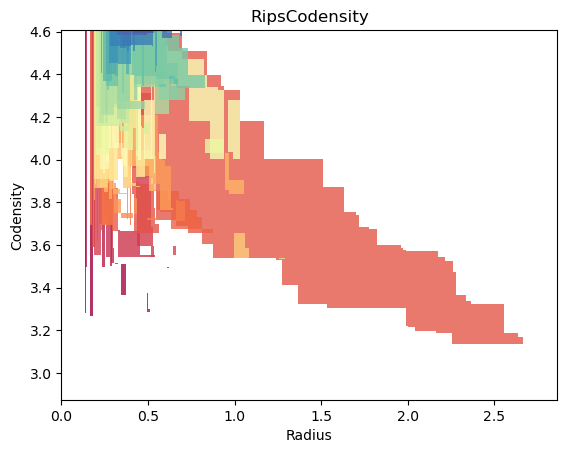

In [9]:
mp.module_approximation(
    st
).plot(degree=1)
plt.xlabel("Radius")
plt.ylabel("Codensity")
plt.title("RipsCodensity")

## Another example (todo)
(maybe a 3-parameter complex ?)